# Machine Learning - Exercise
- ML Lifecycle Samples
- Data load -> EDA -> Preprocessing -> Modeling -> Evaluation (HPO) -> Test

In [1]:
import warnings
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package Load

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, auc, RocCurveDisplay

## Regression

### (1) Housing dataset
- Pipeline 활용

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import scipy.stats as stats

In [6]:
housing = pd.read_csv('./data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
na_sum = housing.isna().sum()
na_sum[na_sum > 0]

total_bedrooms    207
dtype: int64

In [9]:
num_attribs = list(housing.columns.difference(["ocean_proximity", "median_house_value"]))
cat_attribs = ["ocean_proximity"]

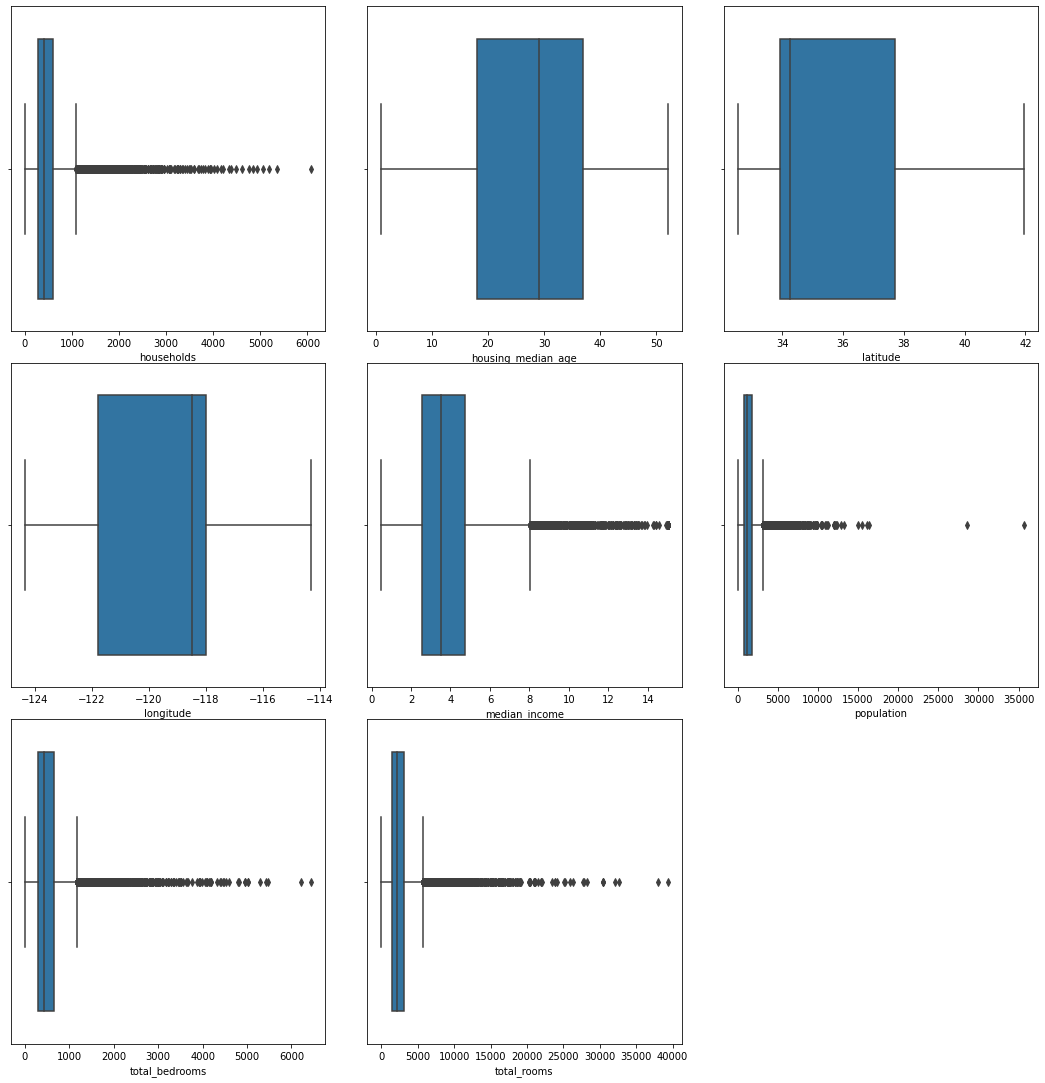

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.tight_layout()
for i, col in enumerate(num_attribs):
    row_ = i//3
    col_ = i%3
    
    sns.boxplot(housing[col], ax=axes[row_][col_])
    
fig.delaxes(axes[2][2]) # subplot 삭제

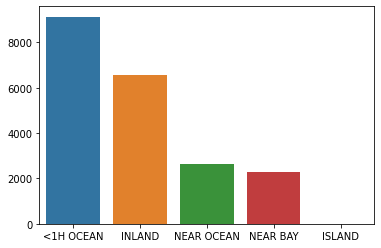

In [11]:
sns.barplot(housing.ocean_proximity.value_counts().index, housing.ocean_proximity.value_counts().values)
plt.show()

In [12]:
### 소득 별로 분할하여 Stratified split
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train = housing.loc[train_index]
    strat_test = housing.loc[test_index]
    
for set_ in (strat_train, strat_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [13]:
### split X, y
housing = strat_train.drop("median_house_value", axis=1)
housing_labels = strat_train["median_house_value"].copy()

In [14]:
### pipeline class
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([ # compose
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [15]:
### Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [16]:
### Pipeline with modeling
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(housing)

array([209664., 320768., 210176., ...,  98432., 215680., 278784.])

In [17]:
### Another models
# Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# SVRegressor
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

SVR(kernel='linear')

In [18]:
### validation
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Decision Tree RMSE:', tree_rmse)

housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('Random Forest RMSE:', forest_rmse)

housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
print('SVR RMSE:', np.sqrt(svm_rmse))

Decision Tree RMSE: 0.0
Random Forest RMSE: 18389.266348432666
SVR RMSE: 334.3707769630634


In [19]:
### Cross Validation
print('Tree model')
score = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-score) # error의 경우 부호를 반대로 해야 함
print(f"점수: {tree_rmse_scores}, 평균: {tree_rmse_scores.mean()}, 표준 편차: {tree_rmse_scores.std()}")

print('\nLinear Regression model')
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-lin_scores)
print(f"점수: {lin_rmse_scores}, 평균: {lin_rmse_scores.mean()}, 표준 편차: {lin_rmse_scores.std()}")

print('\nRandom Forest model')
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
print(f"점수: {forest_rmse_scores}, 평균: {forest_rmse_scores.mean()}, 표준 편차: {forest_rmse_scores.std()}")

print('\nSVR model')
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=3)
svr_rmse_scores = np.sqrt(-svr_scores)
print(f"점수: {svr_rmse_scores}, 평균: {svr_rmse_scores.mean()}, 표준 편차: {svr_rmse_scores.std()}")

Tree model
점수: [69594.22368734 72721.41592045 71275.64477602], 평균: 71197.09479460104, 표준 편차: 1277.8785519752248

Linear Regression model
점수: [69232.58134797 69620.03581451 69512.36911218], 평균: 69454.99542488475, 표준 편차: 163.29736863741803

Random Forest model
점수: [49374.02970885 51470.42102278 51268.83162886], 평균: 50704.4274534966, 표준 편차: 944.326281945737

SVR model
점수: [111358.52592999 115159.31503051 115631.92407928], 평균: 114049.92167992923, 표준 편차: 1912.8596638402157


In [20]:
### Grid search
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [21]:
print('best params:', grid_search.best_params_)
print('best estimator:', grid_search.best_estimator_)

best params: {'max_features': 8, 'n_estimators': 30}
best estimator: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [22]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params) # Grid search 점수 확인

63780.23307729539 {'max_features': 2, 'n_estimators': 3}
56032.46356697792 {'max_features': 2, 'n_estimators': 10}
53290.833499637745 {'max_features': 2, 'n_estimators': 30}
59766.53767358664 {'max_features': 4, 'n_estimators': 3}
53290.372407910036 {'max_features': 4, 'n_estimators': 10}
51112.249465325214 {'max_features': 4, 'n_estimators': 30}
59512.220917791194 {'max_features': 6, 'n_estimators': 3}
52594.29186334187 {'max_features': 6, 'n_estimators': 10}
50974.68218309667 {'max_features': 6, 'n_estimators': 30}
60044.930121477984 {'max_features': 8, 'n_estimators': 3}
52710.97100443604 {'max_features': 8, 'n_estimators': 10}
50823.36053803011 {'max_features': 8, 'n_estimators': 30}
62425.85370304363 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54795.39460416818 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60595.50964245606 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54203.91022490293 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [23]:
### Randomized search
param_distribs = {'n_estimators': np.random.randint(low=1, high=200, size=10),
                  'max_features': np.random.randint(low=1, high=8, size=10)}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': array([7, 1, 2, 6, 6, 2, 1, 5, 7, 4]),
                                        'n_estimators': array([192,  46,  66, 118,  97, 145, 152,  27,  50, 140])},
                   random_state=42, scoring='neg_mean_squared_error')

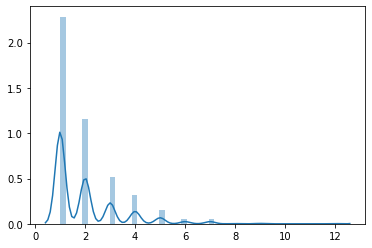

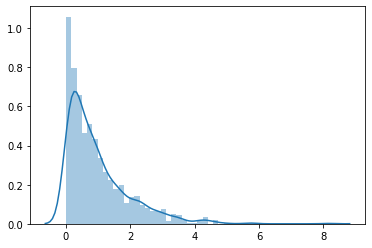

In [24]:
# geom, exponential parameters
geom_distrib = stats.geom(0.5).rvs(1000, random_state=42)
expon_distrib = stats.expon(scale=1).rvs(1000, random_state=42)

sns.distplot(geom_distrib, bins=50)
plt.show()
sns.distplot(expon_distrib, bins=50)
plt.show()

In [25]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49967.25569761605 {'n_estimators': 118, 'max_features': 7}
52278.05429445995 {'n_estimators': 118, 'max_features': 2}
49971.52754432666 {'n_estimators': 192, 'max_features': 5}
50073.01156456172 {'n_estimators': 145, 'max_features': 6}
50205.48493950652 {'n_estimators': 97, 'max_features': 6}
50125.89852496371 {'n_estimators': 140, 'max_features': 6}
52510.29509654979 {'n_estimators': 66, 'max_features': 2}
49928.58518066357 {'n_estimators': 192, 'max_features': 7}
54411.34990169018 {'n_estimators': 192, 'max_features': 1}
49928.58518066357 {'n_estimators': 192, 'max_features': 7}


In [26]:
### Best model, Feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4541800200305063, 'median_income'),
 (0.1409052505408078, 'pop_per_hhold'),
 (0.11267336867122005, 'longitude'),
 (0.10664835902380367, 'latitude'),
 (0.05060203444637723, 'housing_median_age'),
 (0.038123798659333685, 'population'),
 (0.028707404339242473, 'total_rooms'),
 (0.028627777381362816, 'total_bedrooms'),
 (0.02463926505186122, 'households'),
 (0.006331310947437094, 'rooms_per_hhold'),
 (0.006104024573947365, 'INLAND'),
 (0.0023860182106768173, '<1H OCEAN'),
 (7.136812342351712e-05, 'bedrooms_per_room')]

In [27]:
### Test set 사용
final_model = grid_search.best_estimator_

x_test = strat_test.drop("median_house_value", axis=1)
y_test = strat_test["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

print(mean_squared_error(y_test, final_predictions, squared=False))

47423.08938785201


In [28]:
# 95% CI for Test RMSE
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
print(np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))))

# z-score
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(len(squared_errors))
print(np.sqrt(mean - zmargin), np.sqrt(mean + zmargin))

[45466.35583754 49302.22409821]
45466.94204957382 49301.68348887346


### (2) House price dataset
- Stacking

In [29]:
from scipy.stats import skew

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [30]:
house_df_org = pd.read_csv('./data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [31]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())

isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [32]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


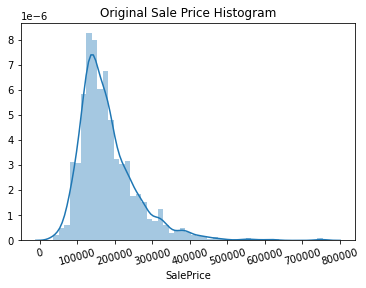

In [33]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.distplot(house_df['SalePrice'], kde=True)
plt.show()

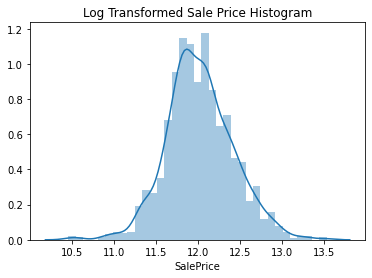

In [34]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice, kde=True)
plt.show()

In [35]:
### SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [36]:
### 독립 변수 로그 변환
# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew()호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# log transformation
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [37]:
house_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,2,2008,WD,Normal,12.247699
1,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,5,2007,WD,Normal,12.109016
2,4.110874,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,9,2008,WD,Normal,12.317171
3,4.262680,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,5.609472,0.0,0.0,0.0,0.000000,2,2006,WD,Abnorml,11.849405
4,4.110874,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,RL,4.143135,8.976894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,8,2007,WD,Normal,12.072547
1456,3.044522,RL,4.454347,9.486152,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.000000,2,2010,WD,Normal,12.254868
1457,4.262680,RL,4.204693,9.109746,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,7.824446,5,2010,WD,Normal,12.493133
1458,3.044522,RL,4.234107,9.181735,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,4.727388,0.0,0.0,0.0,0.000000,4,2010,WD,Normal,11.864469


In [38]:
### One-hot encoding
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


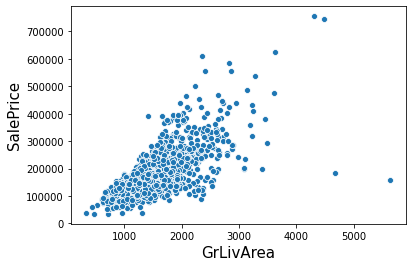

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [39]:
### Outlier 확인
sns.scatterplot(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

### Outlier 삭제
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

In [40]:
### Data split
x = house_df_ohe.drop('SalePrice', axis=1)
y = house_df_ohe['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156)

In [41]:
### Grid Search
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}

grid_model = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('Ridge 5 CV 시 최적 평균 RMSE 값: {0}, 최적 alpha:{1}'.format(np.round(rmse, 4), grid_model.best_params_))
best_ridge = grid_model.best_estimator_

grid_model = GridSearchCV(Lasso(), param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(x, y)
rmse = np.sqrt(-1 * grid_model.best_score_)
print('Lasso 5 CV 시 최적 평균 RMSE 값: {0}, 최적 alpha:{1}'.format(np.round(rmse, 4), grid_model.best_params_))
best_lasso = grid_model.best_estimator_

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


In [42]:
### Linear Regression
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

### Ridge
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(x_train, y_train)

### Lasso
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

### XGBoost
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(x_train, y_train)

### LightGBM
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_reg.fit(x_train, y_train)

[20:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, num_leaves=4,
              reg_lambda=10, subsample=0.6)

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


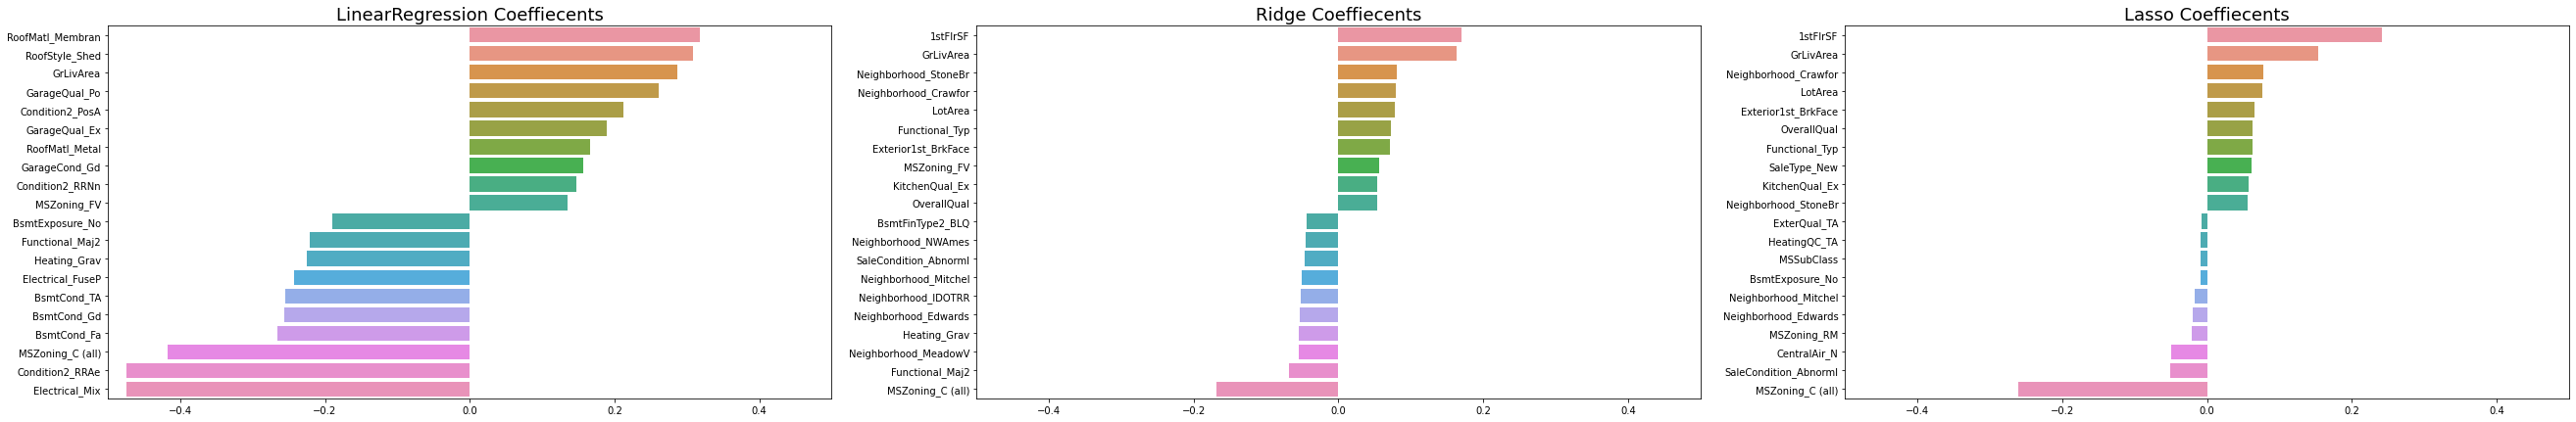

In [43]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
rmses = []
for model in models:
    rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
    rmses.append(rmse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))

# 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
fig, axs = plt.subplots(figsize=(45, 7), nrows=1, ncols=3)

# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
for i_num, model in enumerate(models): 
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=x.columns)

    # 상위 10개, 하위 10개 coefficient 추출
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
        
    coef_concat = pd.concat([coef_high, coef_low])
    # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
    axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=18)
    axs[i_num].tick_params(axis="y")
    axs[i_num].set_xlim([-0.5, 0.5])
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(10)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

XGBRegressor 로그 변환된 RMSE: 0.144
LGBMRegressor 로그 변환된 RMSE: 0.122


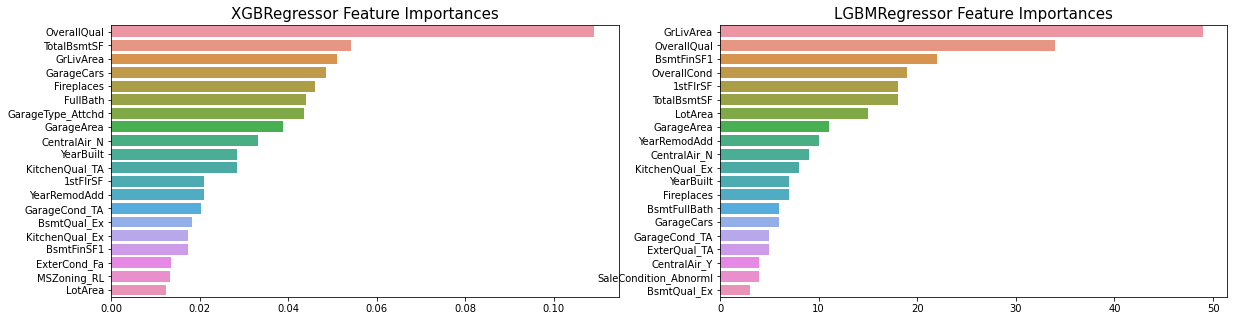

In [44]:
# 모든 모델의 RMSE 출력
models = [xgb_reg, lgbm_reg]
rmses = []
for model in models:
    rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)
    rmses.append(rmse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))

# 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
for i_num, model in enumerate(models):
    # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
    ftr_top20 = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)[:20]
    axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=15)
    
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(10)
    sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

In [45]:
# 개별 모델의 학습
ridge_pred = ridge_reg.predict(x_test)
lasso_pred = lasso_reg.predict(x_test)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.2 * ridge_pred + 0.2 * lasso_pred + 0.3 * xgb_pred + 0.3 * lgbm_pred
preds = {'최종 혼합': pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred, 'XGB': xgb_pred, 'LGBM': lgbm_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
for key in preds.keys():
    print('{0} 모델의 RMSE: {1}'.format(key, mean_squared_error(y_test , preds[key], squared=False)))

최종 혼합 모델의 RMSE: 0.10720678290349332
Ridge 모델의 RMSE: 0.10345177546603247
Lasso 모델의 RMSE: 0.10024170460890042
XGB 모델의 RMSE: 0.1442743418614722
LGBM 모델의 RMSE: 0.12220346943199471


In [46]:
### CV set stacking
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds=5):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__ , ' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index] 
        X_te = X_train_n.iloc[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr) 
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [47]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, x_train, y_train, x_test, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, x_train, y_train, x_test, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, x_train, y_train, x_test, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, x_train, y_train, x_test, 5)

Ridge  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
Lasso  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
XGBRegressor  model 시작
	폴드 세트:  0  시작
[20:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  1  시작
[20:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  2  시작
[20:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  3  시작
[20:34:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	폴드 세트:  4  시작
[20:34:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작


In [48]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
stack_final_x_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
stack_final_x_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(stack_final_x_train, y_train)
print('스태킹 회귀 모델의 최종 RMSE 값은:', mean_squared_error(y_test, meta_model_lasso.predict(stack_final_x_test), squared=False))

스태킹 회귀 모델의 최종 RMSE 값은: 0.09919258723364499


### (3) Bike dataset
- Voting

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [50]:
bike_df = pd.read_csv('./data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [51]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [52]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

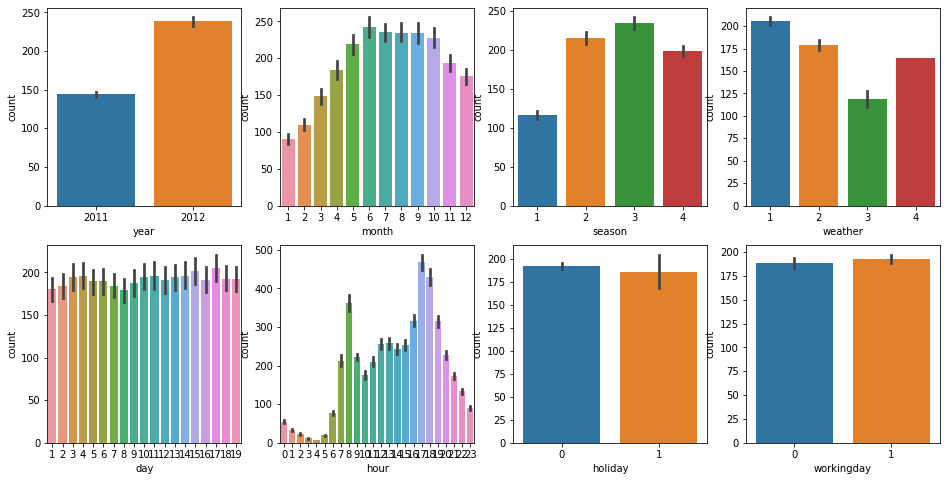

In [53]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4

    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [54]:
x = bike_df.drop(['count'], axis=1, inplace=False)
y = bike_df['count']

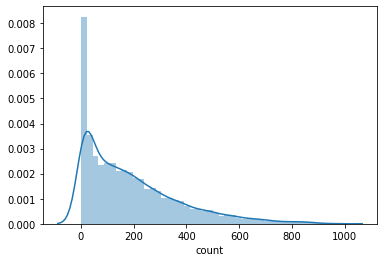

In [55]:
sns.distplot(y)
plt.show()

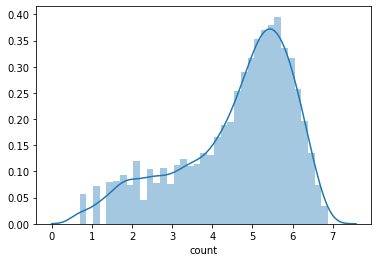

In [56]:
# Log transformation
y_log_transform = np.log1p(y)
sns.distplot(y_log_transform)
plt.show()

In [57]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
x_ohe = pd.get_dummies(x, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_log = np.log1p(y)

# 원-핫 인코딩이 적용된 feature 데이터 세트와 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
x_train, x_test, y_train, y_test = train_test_split(x_ohe, y_log, test_size=0.3, random_state=0)

In [58]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    
    return np.sqrt(np.mean(squared_error))

In [59]:
### Modeling
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

rf_reg = RandomForestRegressor(n_estimators=50)
gbm_reg = GradientBoostingRegressor(n_estimators=50)
xgb_reg = XGBRegressor(n_estimators=50)
lgbm_reg = LGBMRegressor(n_estimators=50)

In [60]:
for model in [lr_reg, ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    model.fit(x_train, y_train)
    pred = np.expm1(model.predict(x_test))

    print('###',model.__class__.__name__,'###')
    rmsle_val = rmsle(y_test, pred)
    rmse_val = mean_squared_error(y_test, pred, squared=True)
    mae_val = mean_absolute_error(y_test, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### LinearRegression ###
RMSLE: 3.102, RMSE: 54235.461, MAE: 173.469
### Ridge ###
RMSLE: 3.092, RMSE: 51710.247, MAE: 170.010
### Lasso ###
RMSLE: 3.056, RMSE: 40791.948, MAE: 154.959
### RandomForestRegressor ###
RMSLE: 3.127, RMSE: 61919.994, MAE: 183.045
### GradientBoostingRegressor ###
RMSLE: 3.011, RMSE: 26850.573, MAE: 136.301
[20:34:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 2.991, RMSE: 25694.808, MAE: 133.356
### LGBMRegressor ###
RMSLE: 3.096, RMSE: 52911.200, MAE: 172.868


In [61]:
### 개별 모델 Voting
vo_reg = VotingRegressor(estimators=[('LR', lr_reg), ('Ridge', ridge_reg), ('Lasso', lasso_reg), ('RF', rf_reg), ('GBM', gbm_reg), ('XGB', xgb_reg), ('LGBM', lgbm_reg)])
vo_reg.fit(x_train, y_train)
pred = vo_reg.predict(x_test)
pred = np.expm1(pred)

rmsle_val = rmsle(y_test, pred)
rmse_val = mean_squared_error(y_test, pred, squared=False)
mae_val = mean_absolute_error(y_test, pred)
print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

[20:34:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 3.058, RMSE: 200.211, MAE: 156.194


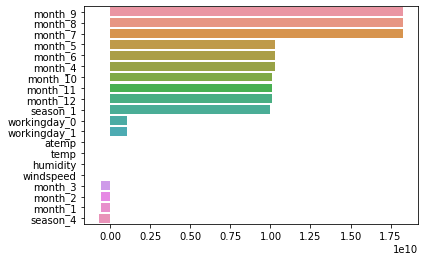

In [62]:
# Linear Regression coef 파악
coef = pd.Series(lr_reg.coef_, index=x_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.show()

In [63]:
# DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성
result_df = pd.DataFrame(y_test.values, columns=['real_count'])
result_df['predicted_count'] = np.round(pred)
result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

# 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
result_df.sort_values('diff', ascending=False)[:5]

,real_count,predicted_count,diff
243,6.357842,707.0,700.642158
637,6.803505,695.0,688.196495
1029,6.804615,668.0,661.195385
751,6.800170,666.0,659.199830
1495,6.708084,662.0,655.291916


## Classification

### (1) Mnist dataset
- Data imbalance and ROC

In [64]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier

In [65]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

x, y = mnist["data"][:10000], mnist["target"][:10000]
print(x.shape, y.shape)

(10000, 784) (10000,)


In [66]:
# y type 변환
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 6, 9, 7], dtype=uint8)

In [67]:
### Data split
x_train, x_test, y_train, y_test = x[:6000], x[6000:], y[:6000], y[6000:]

In [68]:
### Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

In [69]:
### Biranry case로 변경
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [70]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train_scaled, y_train_5)

### Cross Valication
cross_val_score(sgd_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy") ### 아래의 Base model과 비교. 데이터 불균형으로 Base model의 accuracy가 높은 편

array([0.957 , 0.965 , 0.9655])

In [71]:
### Base model
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train_scaled, y_train_5, cv=3, scoring="accuracy")

array([0.91 , 0.915, 0.918])

In [72]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3)

In [73]:
print(confusion_matrix(y_train_5, y_train_pred))
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1-score:", f1_score(y_train_5, y_train_pred))

[[5413   73]
 [ 152  362]]
Precision: 0.832183908045977
Recall: 0.7042801556420234
F1-score: 0.7629083245521602


In [74]:
### score 추출
y_scores = cross_val_predict(sgd_clf, x_train_scaled, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

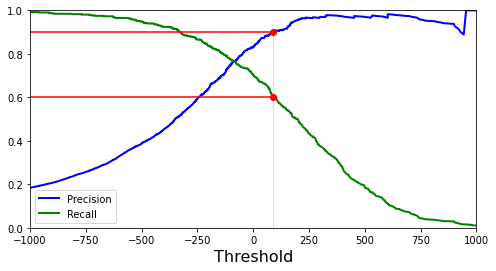

In [75]:
# 90% precision 목표
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
sns.lineplot(x=thresholds, y=precisions[:-1], color='blue', label="Precision", linewidth=2)
sns.lineplot(x=thresholds, y=recalls[:-1], color='green', label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.axis([-1000, 1000, 0, 1])   

sns.lineplot(x=[threshold_90_precision, threshold_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[-1000, threshold_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed') 
sns.lineplot(x=[-1000, threshold_90_precision], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[threshold_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

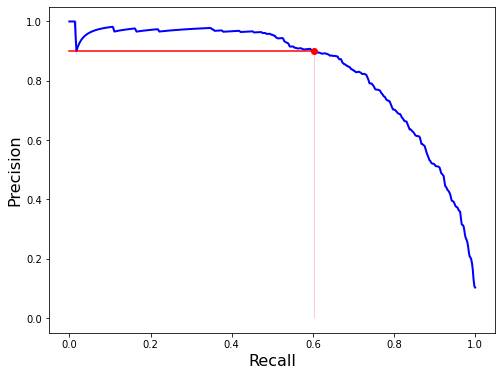

In [76]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=recalls, y=precisions, color="blue", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
    
sns.lineplot(x=[recall_90_precision, recall_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, recall_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[recall_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [77]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

88.73493225972993

In [78]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))
print("F1-score:", f1_score(y_train_5, y_train_pred_90))

Precision: 0.9011627906976745
Recall: 0.603112840466926
F1-score: 0.7226107226107227


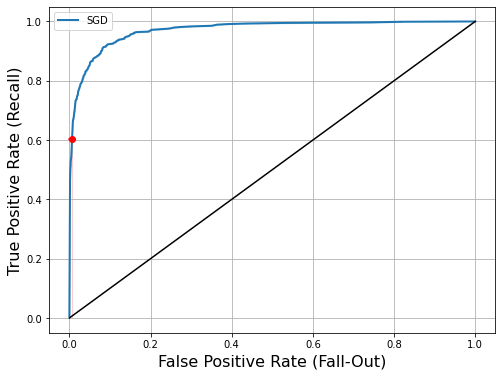

AUC: 0.9713285036832349


In [79]:
### ROC curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6)) 
sns.lineplot(x=fpr, y=tpr, linewidth=2, label='SGD')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")  
plt.show()

print('AUC:', roc_auc_score(y_train_5, y_scores))

In [80]:
### Add RandomForest classifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_train_pred_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3)

print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))
print("F1-score:", f1_score(y_train_5, y_train_pred_forest))

Precision: 0.9886363636363636
Recall: 0.6770428015564203
F1-score: 0.8036951501154735


In [81]:
y_probas_forest = cross_val_predict(forest_clf, x_train_scaled, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
print('AUC:', roc_auc_score(y_train_5, y_scores_forest))

AUC: 0.9935981366080764


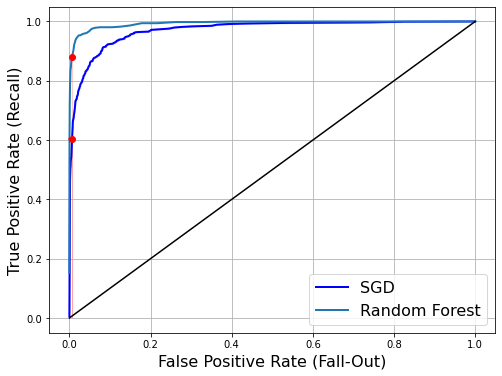

In [82]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, color='blue', linewidth=2, label="SGD")
sns.lineplot(x=fpr_forest, y=tpr_forest, linewidth=2, label="Random Forest")
sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='dashed') # 대각 점선
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, fpr_90], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_90_precision], "ro")
sns.lineplot(x=[fpr_90, fpr_90], y=[0., recall_for_forest], color='red', linestyle='dashed')
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [83]:
### SMOTE 적용
smote = SMOTE()

x_train_sm, y_train_sm = smote.fit_resample(x_train_scaled, y_train_5)
pd.DataFrame(y_train_sm).value_counts()

True     5486
False    5486
dtype: int64

In [84]:
y_scores = cross_val_predict(sgd_clf, x_train_sm, y_train_sm, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_sm, y_scores)

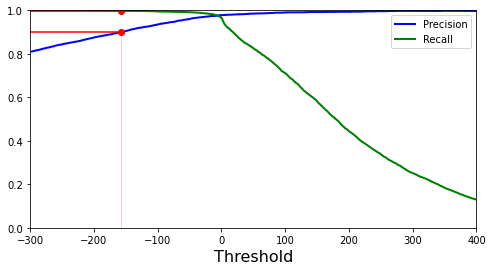

In [85]:
# 90% precision 목표
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
sns.lineplot(x=thresholds, y=precisions[:-1], color='blue', label="Precision", linewidth=2)
sns.lineplot(x=thresholds, y=recalls[:-1], color='green', label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.axis([-300, 400, 0, 1])   

sns.lineplot(x=[threshold_90_precision, threshold_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[-300, threshold_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed') 
sns.lineplot(x=[-300, threshold_90_precision], y=[recall_90_precision, recall_90_precision], color='red', linestyle='dashed')
sns.lineplot(x=[threshold_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

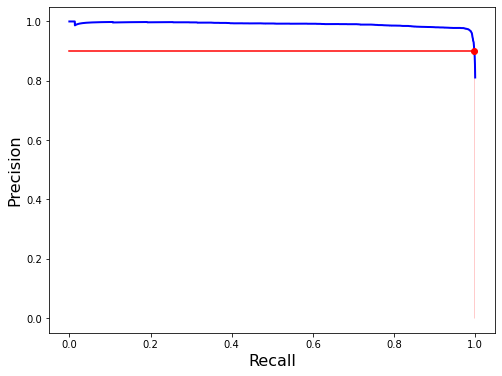

In [86]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=recalls, y=precisions, color="blue", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
    
sns.lineplot(x=[recall_90_precision, recall_90_precision], y=[0., 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[0.0, recall_90_precision], y=[0.9, 0.9], color='red', linestyle='dashed')
sns.lineplot(x=[recall_90_precision], y=[0.9], color='red', linestyle='dashed')
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [87]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-157.2135229558723

In [88]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Recall 증가를 확인할 수 있음
print("Precision:", precision_score(y_train_sm, y_train_pred_90))
print("Recall:", recall_score(y_train_sm, y_train_pred_90))
print("F1-score:", f1_score(y_train_sm, y_train_pred_90))

Precision: 0.9
Recall: 0.997448049580751
F1-score: 0.9462216842469308


### (2) Pima diabete dataset
- Custom Threshold

In [89]:
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.linear_model import LogisticRegression

In [7]:
diabetes_data = pd.read_csv('./data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [8]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [92]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


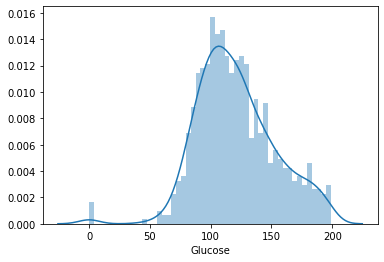

In [93]:
sns.distplot(diabetes_data['Glucose'], bins=50)
plt.show()

In [94]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [95]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [96]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
x = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=156, stratify=y)

In [97]:
### Modeling
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(x_train , y_train)

pred = lr_clf.predict(x_test)
pred_proba = lr_clf.predict_proba(x_test)[:, 1]
    
print('오차 행렬')
print(confusion_matrix(y_test, pred))
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test, pred_proba)))

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433


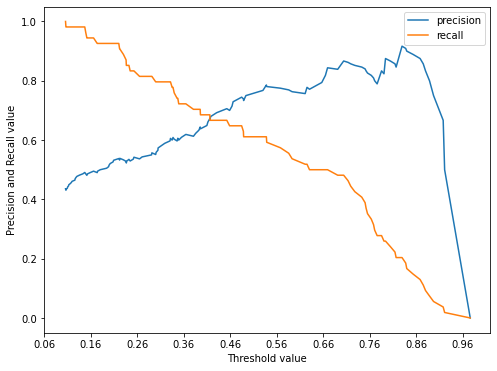

In [98]:
pred_proba_c1 = lr_clf.predict_proba(x_test)[:, 1]

# threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
# X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
plt.figure(figsize=(8, 6))
threshold_boundary = thresholds.shape[0]
sns.lineplot(thresholds, precisions[0:threshold_boundary], label='precision')
sns.lineplot(thresholds, recalls[0:threshold_boundary], label='recall')
    
# threshold 값 X 축의 Scale을 0.1 단위로 변경
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1), 2))
plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
plt.legend()
plt.show()

In [99]:
### 최적 Threshold 확인
thresholds = [0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(x_test)[:, 1].reshape(-1, 1)

for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba) 
    custom_predict = binarizer.transform(pred_proba)
    print('임곗값:', custom_threshold)
    print('오차 행렬')
    print(confusion_matrix(y_test, custom_predict))
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}\n'.format(accuracy_score(y_test, custom_predict), precision_score(y_test, custom_predict), recall_score(y_test, custom_predict), f1_score(y_test, custom_predict), roc_auc_score(y_test, pred_proba)))

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667, AUC:0.8433

임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1: 0.6667, AUC:0.8433

임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792, AUC:0.8433

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857, AUC:0.8433

임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433



In [100]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba) 

confusion = confusion_matrix(y_test, pred_th_048)
accuracy = accuracy_score(y_test, pred_th_048)
precision = precision_score(y_test, pred_th_048)
recall = recall_score(y_test, pred_th_048)
f1 = f1_score(y_test, pred_th_048)
roc_auc = roc_auc_score(y_test, pred_proba)
    
print('오차 행렬')
print(confusion)
print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433


### (3) StageC dataset
- DecisionTree, RandomForest

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image

In [102]:
stagec = pd.read_csv('./data/stagec.csv')

In [103]:
stagec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pgtime   146 non-null    float64
 1   pgstat   146 non-null    int64  
 2   age      146 non-null    int64  
 3   eet      144 non-null    float64
 4   g2       139 non-null    float64
 5   grade    146 non-null    int64  
 6   gleason  143 non-null    float64
 7   ploidy   146 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 9.2+ KB


In [104]:
stagec.isna().sum()

pgtime     0
pgstat     0
age        0
eet        2
g2         7
grade      0
gleason    3
ploidy     0
dtype: int64

In [105]:
### dropNA
stagec = stagec.dropna()
stagec.head()

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy
0,6.1,0,64,2.0,10.26,2,4.0,diploid
2,5.2,1,59,2.0,9.99,3,7.0,diploid
3,3.2,1,62,2.0,3.57,2,4.0,diploid
4,1.9,1,64,2.0,22.56,4,8.0,tetraploid
5,4.8,0,69,1.0,6.14,3,7.0,diploid


In [106]:
cat_col = ['eet', 'pgstat']
num_col = stagec.columns.difference(['ploidy'] + cat_col)

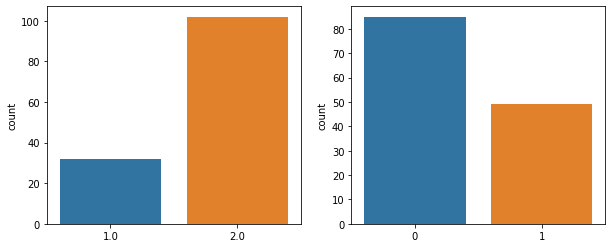

In [107]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for i, col in enumerate(cat_col):
    sns.countplot(x=stagec[col].values, ax=axes[i])

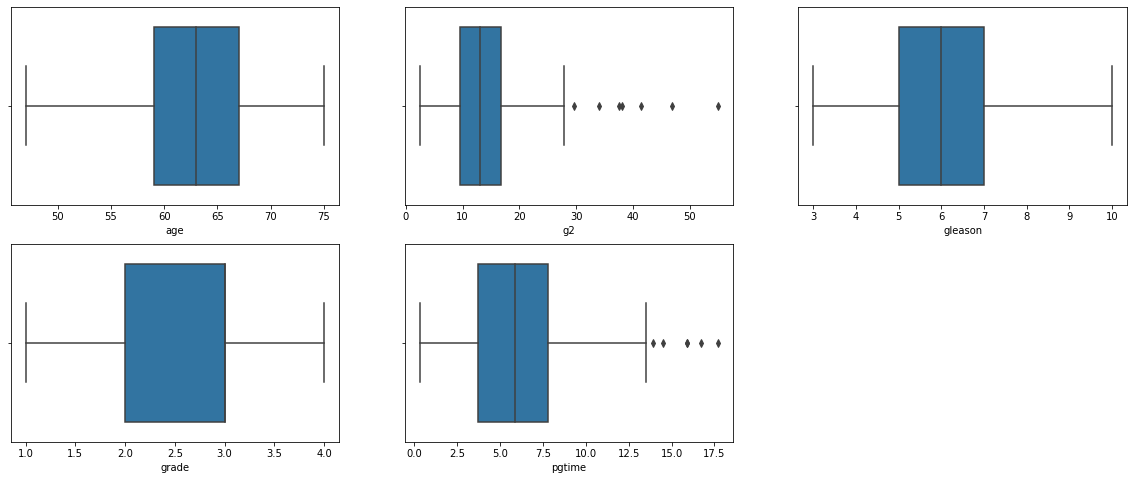

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
for i, col in enumerate(num_col):
    row_ = i//3
    col_ = i%3
    sns.boxplot(x=col, data=stagec, ax=axes[row_][col_])
    
fig.delaxes(axes[1][2]) # subplot 삭제

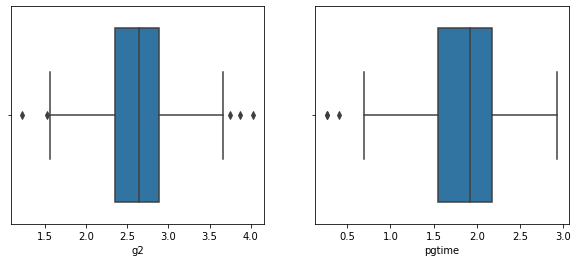

In [109]:
### log transformation
log_col = ['g2', 'pgtime']

for col in log_col:
    stagec[col] = np.log1p(stagec[col])

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for i, col in enumerate(log_col):
    sns.boxplot(x=stagec[col], ax=axes[i])

In [110]:
### Data split
x_train, x_test, y_train, y_test = train_test_split(stagec.drop('ploidy', axis=1), stagec['ploidy'], test_size=0.2, random_state=0, stratify=stagec['ploidy'])

In [111]:
### Decision Tree
dtree_clf = DecisionTreeClassifier(max_depth=3, random_state=100)
dtree_clf.fit(x_train, y_train)

### Random Forest
rand_clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)
rand_clf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=5)

In [112]:
### Predict
tree_pred = dtree_clf.predict(x_test)
print(confusion_matrix(y_test, tree_pred))
print('Tree 정확도\t{}%'.format(round(accuracy_score(y_test, tree_pred) *100,2)))

rf_pred = rand_clf.predict(x_test)
print(confusion_matrix(y_test, rf_pred))
print('Random Forest 정확도\t{}%'.format(round(accuracy_score(y_test, rf_pred) * 100, 2)))

[[ 0  1  0]
 [ 1 12  0]
 [ 0  0 13]]
Tree 정확도	92.59%
[[ 0  1  0]
 [ 0 13  0]
 [ 0  0 13]]
Random Forest 정확도	96.3%


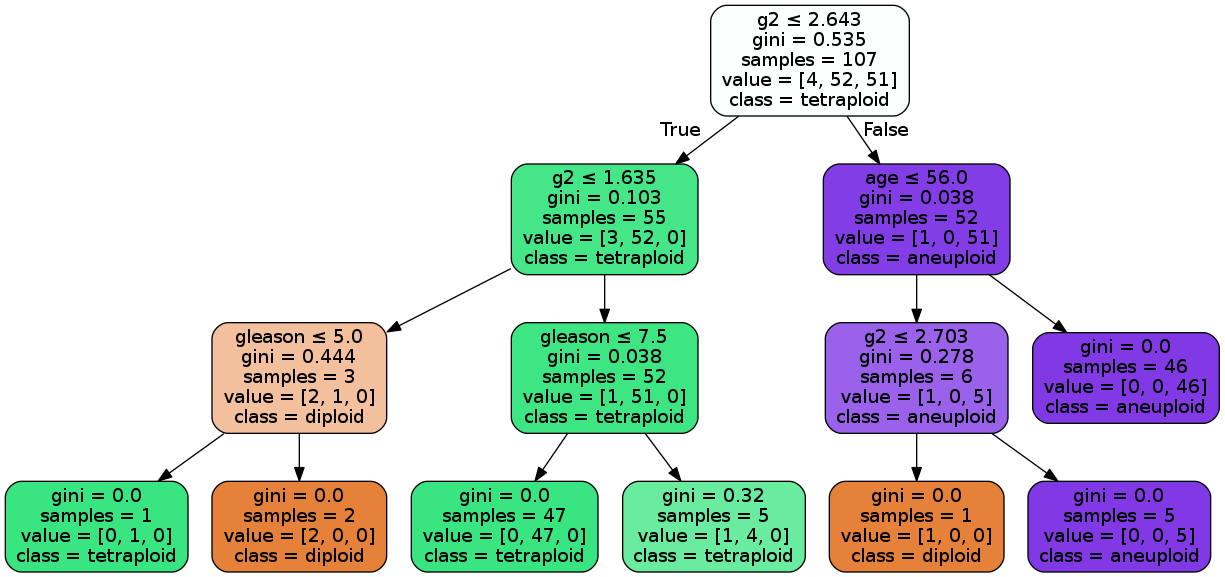

In [113]:
### Tree 시각화
feature_names = x_train.columns
target_names = np.array(list(stagec.ploidy.unique()))

dt_dot_data = export_graphviz(dtree_clf, feature_names = feature_names,
                              class_names = target_names,
                              filled=True, rounded =True,
                              special_characters=True)
dt_graph=pydotplus.graph_from_dot_data(dt_dot_data)
Image(dt_graph.create_png())

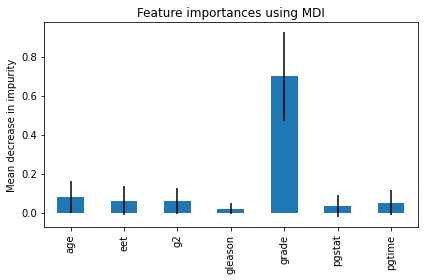

In [114]:
### RandomForest Feature importance
forest_importances = pd.Series(rand_clf.feature_importances_, index=list(stagec.columns.difference(['ploidy'])))

forest_importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in rand_clf.estimators_], axis=0))
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()

### (4) Human activity dataset
- Deecision Tree
- Grid Search

In [115]:
from sklearn.tree import DecisionTreeClassifier

In [116]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [117]:
# feature 중복 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [118]:
# 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
# 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
feature_dup_df = pd.DataFrame(data=feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
feature_dup_df = feature_dup_df.reset_index()
new_feature_name_df = pd.merge(feature_name_df.reset_index(), feature_dup_df, how='outer')
new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0] ,  axis=1)
new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    
# DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
x_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name)
x_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
# 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
y_train = pd.read_csv('./data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
y_test = pd.read_csv('./data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

In [119]:
print('## 학습 피처 데이터셋 info()')
x_train.info()

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [120]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [121]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [122]:
params = {'max_depth': [6, 8 ,10, 12, 16 ,20, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=3, verbose=1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

Fitting 3 folds for each of 7 candidates, totalling 21 fits
GridSearchCV 최고 평균 정확도 수치:0.8473
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 6}


,param_max_depth,mean_test_score
0,6,0.847251
1,8,0.837323
2,10,0.829567
3,12,0.827663
4,16,0.827393
5,20,0.831201
6,24,0.831201


In [123]:
for depth in [6, 8 ,10, 12, 16 ,20, 24]:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(x_train, y_train)

    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy_score(y_test, dt_clf.predict(x_test))))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [124]:
params = {'max_depth': [8 , 12, 16, 20], 'min_samples_split': [16, 24]}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [125]:
best_df_clf = grid_cv.best_estimator_
pred = best_df_clf.predict(x_test)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy_score(y_test , pred)))

결정 트리 예측 정확도:0.8717


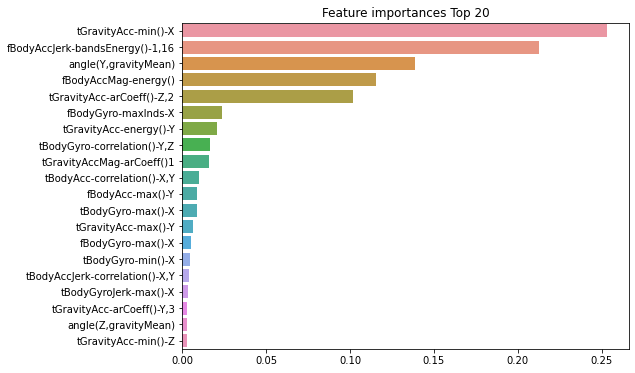

In [126]:
ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### (5) Santander bank dataset
- XGBoost, LightGBM
- Bayes HPO

In [127]:
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier

from hyperopt import hp
from hyperopt import fmin, tpe, Trials

In [128]:
cust_df = pd.read_csv("./data/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [129]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [130]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [131]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [132]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
x_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(x_features.shape))

피처 데이터 shape:(76020, 369)


In [133]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(x_train.shape, x_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

# x_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [134]:
# n_estimators는 50으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 20으로 설정하고 학습 수행.
# label 비율이 비대칭이므로
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc', eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.803388	validation_1-auc:0.797852
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.812619	validation_1-auc:0.796774
[2]	validation_0-auc:0.811648	validation_1-auc:0.798697
[3]	validation_0-auc:0.812568	validation_1-auc:0.797626
[4]	validation_0-auc:0.814884	validation_1-auc:0.798837
[5]	validation_0-auc:0.814676	validation_1-auc:0.80085
[6]	validation_0-auc:0.814879	validation_1-auc:0.799201
[7]	validation_0-auc:0.815144	validation_1-auc:0.798952
[8]	validation_0-auc:0.81629	validation_1-auc:0.801921
[9]	validation_0-auc:0.816236	validation_1-auc:0.800339
[10]	validation_0-auc:0.815842	validation_1-auc:0.80191
[11]	validation_0-auc:0.816102	validation_1-auc:0.800052
[12]	validation_0-auc:0.818573	validation_1-auc:0.805199
[13]	validation_0-auc:0.816937	validation_1-auc:0.801944
[14]	validation_0-auc:0.816405	validation_1-auc:0.801992
[

In [135]:
# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [136]:
# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=30, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(x_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric='auc',
                   eval_set=[(x_tr, y_tr), (x_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(x_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [137]:
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=5, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.RandomState(30)) # random number generator

print('best:', best)

[0]	validation_0-auc:0.827743	validation_1-auc:0.800259

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 20 rounds.

[1]	validation_0-auc:0.836462	validation_1-auc:0.804948

[2]	validation_0-auc:0.845275	validation_1-auc:0.811651

[3]	validation_0-auc:0.846178	validation_1-auc:0.811944

[4]	validation_0-auc:0.848543	validation_1-auc:0.812161

[5]	validation_0-auc:0.85132	validation_1-auc:0.813583

[6]	validation_0-auc:0.85421	validation_1-auc:0.815293

[7]	validation_0-auc:0.856616	validation_1-auc:0.816767

[8]	validation_0-auc:0.859391	validation_1-auc:0.816898

[9]	validation_0-auc:0.863084	validation_1-auc:0.819714

[10]	validation_0-auc:0.865189	validation_1-auc:0.820449

[11]	validation_0-auc:0.866979	validation_1-auc:0.820777

[12]	validation_0-auc:0.869243	validation_1-auc:0.821747

[13]	validation_0-auc:0.873527	validation_1-auc:0.824457

[14]	validation_0-auc:0.876743	validation

[4]	validation_0-auc:0.84262	validation_1-auc:0.826568                       

[5]	validation_0-auc:0.847781	validation_1-auc:0.828172                      

[6]	validation_0-auc:0.851781	validation_1-auc:0.830639                      

[7]	validation_0-auc:0.853583	validation_1-auc:0.830626                      

[8]	validation_0-auc:0.857658	validation_1-auc:0.830825                      

[9]	validation_0-auc:0.858775	validation_1-auc:0.830242                      

[10]	validation_0-auc:0.8613	validation_1-auc:0.830247                       

[11]	validation_0-auc:0.863565	validation_1-auc:0.831483                     

[12]	validation_0-auc:0.864961	validation_1-auc:0.832562                     

[13]	validation_0-auc:0.867092	validation_1-auc:0.832849                     

[14]	validation_0-auc:0.868469	validation_1-auc:0.832553                     

[15]	validation_0-auc:0.870029	validation_1-auc:0.832891                     

[16]	validation_0-auc:0.871571	validation_1-auc:0.83

[18]	validation_0-auc:0.898141	validation_1-auc:0.831915                     

[19]	validation_0-auc:0.899425	validation_1-auc:0.83236                      

[20]	validation_0-auc:0.900738	validation_1-auc:0.832843                     

[21]	validation_0-auc:0.902235	validation_1-auc:0.831607                     

[22]	validation_0-auc:0.903733	validation_1-auc:0.832362                     

[23]	validation_0-auc:0.904763	validation_1-auc:0.833055                     

[24]	validation_0-auc:0.905377	validation_1-auc:0.833264                     

[25]	validation_0-auc:0.906722	validation_1-auc:0.833769                     

[26]	validation_0-auc:0.908538	validation_1-auc:0.833785                     

[27]	validation_0-auc:0.910237	validation_1-auc:0.832707                     

[28]	validation_0-auc:0.912065	validation_1-auc:0.832487                     

[29]	validation_0-auc:0.913575	validation_1-auc:0.831867                     

[0]	validation_0-auc:0.832173	validation_1-auc:0.809

In [138]:
# 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5))

# evaluation metric을 auc로, early stopping은 20 으로 설정하고 학습 수행. 
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=20, eval_metric="auc",eval_set=[(x_tr, y_tr), (x_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.827215	validation_1-auc:0.806623
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.836491	validation_1-auc:0.81023
[2]	validation_0-auc:0.83992	validation_1-auc:0.812403
[3]	validation_0-auc:0.845532	validation_1-auc:0.81646
[4]	validation_0-auc:0.849425	validation_1-auc:0.819563
[5]	validation_0-auc:0.850344	validation_1-auc:0.819842
[6]	validation_0-auc:0.856107	validation_1-auc:0.820065
[7]	validation_0-auc:0.859344	validation_1-auc:0.820933
[8]	validation_0-auc:0.861993	validation_1-auc:0.821161
[9]	validation_0-auc:0.863445	validation_1-auc:0.820446
[10]	validation_0-auc:0.864817	validation_1-auc:0.820823
[11]	validation_0-auc:0.86706	validation_1-auc:0.82094
[12]	validation_0-auc:0.872011	validation_1-auc:0.823858
[13]	validation_0-auc:0.875412	validation_1-auc:0.826942
[14]	validation_0-auc:0.878406	validation_1-auc:0.82631
[15]

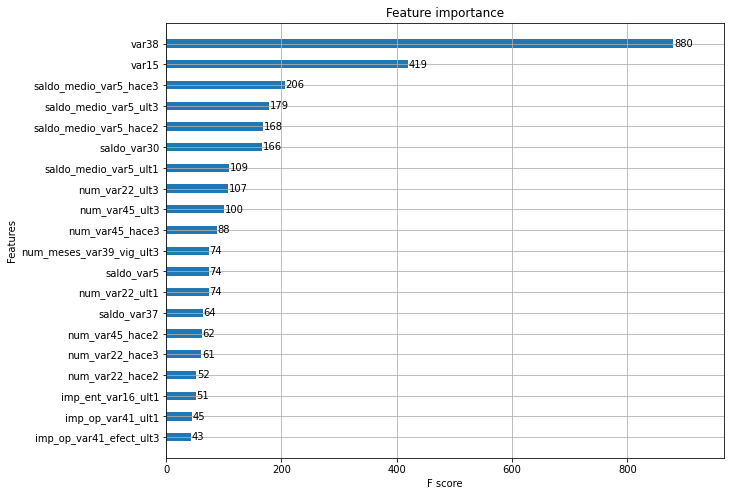

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()

In [140]:
lgbm_clf = LGBMClassifier(n_estimators=50)

eval_set=[(x_tr, y_tr), (x_val, y_val)]
lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=20)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
Training until validation scores don't improve for 20 rounds.
[2]	training's auc: 0.833881	training's binary_logloss: 0.149605	valid_1's auc: 0.81209	valid_1's binary_logloss: 0.153277
[3]	training's auc: 0.839548	training's binary_logloss: 0.145485	valid_1's auc: 0.814018	valid_1's binary_logloss: 0.150052
[4]	training's auc: 0.845749	training's binary_logloss: 0.142197	valid_1's auc: 0.819257	valid_1's binary_logloss: 0.147501
[5]	training's auc: 0.848218	training's binary_logloss: 0.139595	valid_1's auc: 0.821853	valid_1's binary_logloss: 0.145477
[6]	training's auc: 0.853054	training's binary_logloss: 0.137401	valid_1's auc: 0.822606	valid_1's binary_logloss: 0.144005
[7]	training's auc: 0.854533	training's binary_logloss: 0.135455	valid_1's auc: 0.823109	valid_1's binary_logloss: 0.14262
[8]	training's auc: 0.858009	training's binary_logloss: 0.133684	valid_1's 

In [141]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [142]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=50, num_leaves=int(search_space['num_leaves']), max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), subsample=search_space['subsample'], learning_rate=search_space['learning_rate'])

    roc_auc_list = []
    kf = KFold(n_splits=3)
    # x_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(x_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 20회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
        lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=20)

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(x_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [143]:
# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=3, trials=Trials(), rstate=np.random.RandomState(30))
print('best:', best)

[1]	valid_0's auc: 0.830702	valid_0's binary_logloss: 0.150371	valid_1's auc: 0.820277	valid_1's binary_logloss: 0.151991
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.843267	valid_0's binary_logloss: 0.14414	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.146138
[3]	valid_0's auc: 0.846494	valid_0's binary_logloss: 0.140123	valid_1's auc: 0.841687	valid_1's binary_logloss: 0.141971
[4]	valid_0's auc: 0.852648	valid_0's binary_logloss: 0.137028	valid_1's auc: 0.847405	valid_1's binary_logloss: 0.138952
[5]	valid_0's auc: 0.853998	valid_0's binary_logloss: 0.13478	valid_1's auc: 0.849961	valid_1's binary_logloss: 0.136614
[6]	valid_0's auc: 0.85718	valid_0's binary_logloss: 0.132734	valid_1's auc: 0.85172	valid_1's binary_logloss: 0.134729
[7]	valid_0's auc: 0.859278	valid_0's binary_logloss: 0.131215	valid_1's auc: 0.852053	valid_1's binary_logloss: 0.133371
[8]	valid_0's auc: 0.861571	valid_0's binary_logloss: 0.129986	valid_1's auc: 0.8541	val

[16]	valid_0's auc: 0.877732	valid_0's binary_logloss: 0.123065	valid_1's auc: 0.870932	valid_1's binary_logloss: 0.125679
[17]	valid_0's auc: 0.879163	valid_0's binary_logloss: 0.122515	valid_1's auc: 0.873218	valid_1's binary_logloss: 0.125138
[18]	valid_0's auc: 0.880345	valid_0's binary_logloss: 0.121969	valid_1's auc: 0.874085	valid_1's binary_logloss: 0.124654
[19]	valid_0's auc: 0.881748	valid_0's binary_logloss: 0.121429	valid_1's auc: 0.876248	valid_1's binary_logloss: 0.12403
[20]	valid_0's auc: 0.883228	valid_0's binary_logloss: 0.120902	valid_1's auc: 0.876817	valid_1's binary_logloss: 0.123704
[21]	valid_0's auc: 0.884543	valid_0's binary_logloss: 0.120426	valid_1's auc: 0.878977	valid_1's binary_logloss: 0.123145
[22]	valid_0's auc: 0.885614	valid_0's binary_logloss: 0.119948	valid_1's auc: 0.880264	valid_1's binary_logloss: 0.122736
[23]	valid_0's auc: 0.886925	valid_0's binary_logloss: 0.119514	valid_1's auc: 0.881882	valid_1's binary_logloss: 0.122279
[24]	valid_0's au

[31]	valid_0's auc: 0.891608	valid_0's binary_logloss: 0.116522	valid_1's auc: 0.887804	valid_1's binary_logloss: 0.119323
[32]	valid_0's auc: 0.891841	valid_0's binary_logloss: 0.116244	valid_1's auc: 0.888291	valid_1's binary_logloss: 0.119089
[33]	valid_0's auc: 0.89266	valid_0's binary_logloss: 0.115933	valid_1's auc: 0.889304	valid_1's binary_logloss: 0.118749
[34]	valid_0's auc: 0.893087	valid_0's binary_logloss: 0.115593	valid_1's auc: 0.889407	valid_1's binary_logloss: 0.118493
[35]	valid_0's auc: 0.893615	valid_0's binary_logloss: 0.1153	valid_1's auc: 0.889853	valid_1's binary_logloss: 0.118204
[36]	valid_0's auc: 0.894172	valid_0's binary_logloss: 0.115072	valid_1's auc: 0.890424	valid_1's binary_logloss: 0.11794
[37]	valid_0's auc: 0.894968	valid_0's binary_logloss: 0.114782	valid_1's auc: 0.89108	valid_1's binary_logloss: 0.117666
[38]	valid_0's auc: 0.895399	valid_0's binary_logloss: 0.114472	valid_1's auc: 0.89151	valid_1's binary_logloss: 0.117413
[39]	valid_0's auc: 0.

[46]	valid_0's auc: 0.875549	valid_0's binary_logloss: 0.125104	valid_1's auc: 0.869165	valid_1's binary_logloss: 0.126881
[47]	valid_0's auc: 0.876029	valid_0's binary_logloss: 0.124881	valid_1's auc: 0.869669	valid_1's binary_logloss: 0.126642
[48]	valid_0's auc: 0.876529	valid_0's binary_logloss: 0.124646	valid_1's auc: 0.870158	valid_1's binary_logloss: 0.1264
[49]	valid_0's auc: 0.876833	valid_0's binary_logloss: 0.124448	valid_1's auc: 0.87063	valid_1's binary_logloss: 0.126214
[50]	valid_0's auc: 0.877296	valid_0's binary_logloss: 0.124221	valid_1's auc: 0.870846	valid_1's binary_logloss: 0.126031
Did not meet early stopping. Best iteration is:                              
[50]	valid_0's auc: 0.877296	valid_0's binary_logloss: 0.124221	valid_1's auc: 0.870846	valid_1's binary_logloss: 0.126031
[1]	valid_0's auc: 0.830552	valid_0's binary_logloss: 0.160552	valid_1's auc: 0.829085	valid_1's binary_logloss: 0.161624
Training until validation scores don't improve for 20 rounds.    

[23]	valid_0's auc: 0.858905	valid_0's binary_logloss: 0.131885	valid_1's auc: 0.855446	valid_1's binary_logloss: 0.133081
[24]	valid_0's auc: 0.859577	valid_0's binary_logloss: 0.13146	valid_1's auc: 0.855943	valid_1's binary_logloss: 0.132671
[25]	valid_0's auc: 0.860599	valid_0's binary_logloss: 0.131023	valid_1's auc: 0.856136	valid_1's binary_logloss: 0.132343
[26]	valid_0's auc: 0.861123	valid_0's binary_logloss: 0.13065	valid_1's auc: 0.856576	valid_1's binary_logloss: 0.131968
[27]	valid_0's auc: 0.861909	valid_0's binary_logloss: 0.130253	valid_1's auc: 0.856695	valid_1's binary_logloss: 0.13163
[28]	valid_0's auc: 0.862537	valid_0's binary_logloss: 0.129906	valid_1's auc: 0.857042	valid_1's binary_logloss: 0.131327
[29]	valid_0's auc: 0.863371	valid_0's binary_logloss: 0.129559	valid_1's auc: 0.857562	valid_1's binary_logloss: 0.131016
[30]	valid_0's auc: 0.86395	valid_0's binary_logloss: 0.129229	valid_1's auc: 0.857665	valid_1's binary_logloss: 0.13075
[31]	valid_0's auc: 0

100%|██████████| 3/3 [00:22<00:00,  7.66s/it, best loss: -0.8340680156079272]
best: {'learning_rate': 0.054504468356852624, 'max_depth': 135.0, 'min_child_samples': 98.0, 'num_leaves': 36.0, 'subsample': 0.8488007648764272}


In [144]:
lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=int(best['num_leaves']), max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),  subsample=round(best['subsample'], 5), learning_rate=round(best['learning_rate'], 5))

lgbm_clf.fit(x_tr, y_tr, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=20)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(x_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.82929	valid_0's binary_logloss: 0.159463	valid_1's auc: 0.803474	valid_1's binary_logloss: 0.161406
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.836051	valid_0's binary_logloss: 0.155572	valid_1's auc: 0.810452	valid_1's binary_logloss: 0.158087
[3]	valid_0's auc: 0.839125	valid_0's binary_logloss: 0.152374	valid_1's auc: 0.813014	valid_1's binary_logloss: 0.155347
[4]	valid_0's auc: 0.84285	valid_0's binary_logloss: 0.149725	valid_1's auc: 0.814578	valid_1's binary_logloss: 0.153105
[5]	valid_0's auc: 0.845559	valid_0's binary_logloss: 0.147449	valid_1's auc: 0.815652	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.847878	valid_0's binary_logloss: 0.145488	valid_1's auc: 0.818362	valid_1's binary_logloss: 0.149634
[7]	valid_0's auc: 0.852358	valid_0's binary_logloss: 0.143697	valid_1's auc: 0.822141	valid_1's binary_logloss: 0.148208
[8]	valid_0's auc: 0.853397	valid_0's binary_logloss: 0.142177	valid_1's auc: 0.822808

[74]	valid_0's auc: 0.906173	valid_0's binary_logloss: 0.115435	valid_1's auc: 0.832729	valid_1's binary_logloss: 0.134938
[75]	valid_0's auc: 0.906557	valid_0's binary_logloss: 0.115257	valid_1's auc: 0.832573	valid_1's binary_logloss: 0.134978
[76]	valid_0's auc: 0.907181	valid_0's binary_logloss: 0.115099	valid_1's auc: 0.832572	valid_1's binary_logloss: 0.134982
[77]	valid_0's auc: 0.90751	valid_0's binary_logloss: 0.114954	valid_1's auc: 0.832518	valid_1's binary_logloss: 0.134981
[78]	valid_0's auc: 0.907972	valid_0's binary_logloss: 0.114776	valid_1's auc: 0.832375	valid_1's binary_logloss: 0.135013
[79]	valid_0's auc: 0.90837	valid_0's binary_logloss: 0.114595	valid_1's auc: 0.8323	valid_1's binary_logloss: 0.135033
[80]	valid_0's auc: 0.908888	valid_0's binary_logloss: 0.114415	valid_1's auc: 0.832068	valid_1's binary_logloss: 0.135057
[81]	valid_0's auc: 0.90922	valid_0's binary_logloss: 0.114258	valid_1's auc: 0.832147	valid_1's binary_logloss: 0.135035
[82]	valid_0's auc: 0

### (6) Infert dataset

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [146]:
### Infert data
infert = pd.read_csv('./r_csv/datasets/infert.csv', index_col='Unnamed: 0')
infert.head()

,education,age,parity,induced,case,spontaneous,stratum,pooled.stratum
1,0-5yrs,26,6,1,1,2,1,3
2,0-5yrs,42,1,1,1,0,2,1
3,0-5yrs,39,6,2,1,0,3,4
4,0-5yrs,34,4,2,1,0,4,2
5,6-11yrs,35,3,1,1,1,5,32


In [147]:
infert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 1 to 248
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   education       248 non-null    object
 1   age             248 non-null    int64 
 2   parity          248 non-null    int64 
 3   induced         248 non-null    int64 
 4   case            248 non-null    int64 
 5   spontaneous     248 non-null    int64 
 6   stratum         248 non-null    int64 
 7   pooled.stratum  248 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 17.4+ KB


In [148]:
x = infert.drop(['case', 'education', 'stratum', 'pooled.stratum'], axis=1)
y = infert['case']

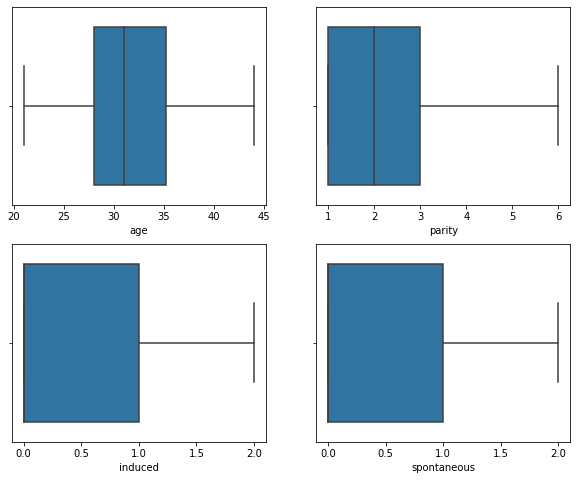

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, col in enumerate(x.columns):
    row_ = i//2
    col_ = i%2
    
    sns.boxplot(infert[col], ax=axes[row_][col_])

In [150]:
### Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=infert['case'])

In [151]:
### Modeling
# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_preds = lr_clf.predict(x_test)

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test , lr_preds)))

accuracy: 0.740, roc_auc:0.646


In [152]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(x_train, y_train)
    lr_preds = lr_clf.predict(x_test)
    
    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test , lr_preds)))

solver:lbfgs, accuracy: 0.740, roc_auc:0.646
solver:liblinear, accuracy: 0.720, roc_auc:0.631
solver:newton-cg, accuracy: 0.740, roc_auc:0.646
solver:sag, accuracy: 0.740, roc_auc:0.646
solver:saga, accuracy: 0.720, roc_auc:0.645


In [153]:
params={'solver':['liblinear', 'lbfgs'], 'penalty':['l2', 'l1'], 'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression()
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(x_train, y_train)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}, 최적 평균 정확도:0.722


In [154]:
mlp = MLPClassifier(solver="lbfgs", alpha=1, hidden_layer_sizes=(4, 2), random_state=1)
mlp.fit(x_train, y_train)

MLPClassifier(alpha=1, hidden_layer_sizes=(4, 2), random_state=1,
              solver='lbfgs')

In [155]:
pred = mlp.predict(x_test)

print(confusion_matrix(y_test, pred))
print('정확도\t{}'.format(accuracy_score(y_test, pred)))
print('정밀도\t{}'.format(precision_score(y_test, pred, average=None)))
print('재현율\t{}'.format(recall_score(y_test, pred, average=None)))
print('F1\t{}%'.format(f1_score(y_test, pred, average=None)))

[[26  7]
 [ 9  8]]
정확도	0.68
정밀도	[0.74285714 0.53333333]
재현율	[0.78787879 0.47058824]
F1	[0.76470588 0.5       ]%


In [156]:
mlp.coefs_

[array([[-0.64120462,  0.0134362 , -0.59521665, -0.14260375],
        [-0.13946746,  0.3459954 , -0.12134571, -0.0305479 ],
        [-0.00809124, -0.57814227, -0.00632928,  0.0232679 ],
        [-0.08241403, -1.07721879, -0.11995102,  0.0204451 ]]),
 array([[ 0.04701729,  0.09740613],
        [-0.02916857,  1.37006628],
        [ 0.05884329,  0.12690441],
        [-0.06487265, -0.07255339]]),
 array([[-0.08880267],
        [-1.44560537]])]

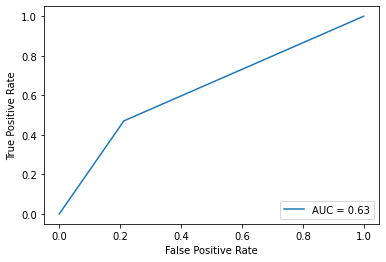

In [157]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
# plot_roc_curve(mlp, x_test, y_test) # plot_roc_curve
plt.show()

### (8) Loan default dataset
- KNN, KNN as a variable

In [158]:
import random

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [160]:
loan200 = pd.read_csv("./data/loan200.csv")
predictors = ['payment_inc_ratio', 'dti']

x = loan200.loc[1:, predictors]
y = loan200.loc[1:, 'outcome']
pd.concat([x, y], axis=1)

,payment_inc_ratio,dti,outcome
1,5.46933,21.33,default
2,6.90294,8.97,paid off
3,11.14800,1.83,paid off
4,3.72120,10.81,default
5,1.89923,11.34,paid off
...,...,...,...
196,11.66300,26.09,default
197,2.97641,16.41,default
198,1.96846,19.98,default
199,9.64200,20.17,paid off


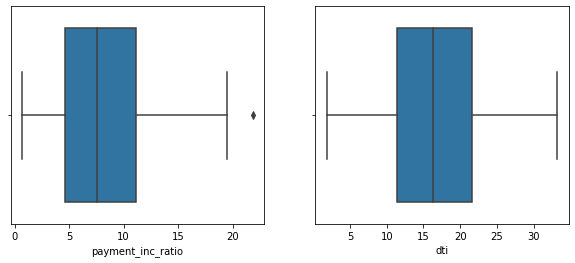

In [161]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for i, col in enumerate(predictors):
    sns.boxplot(loan200[col], ax=axes[i])

In [162]:
loan200.outcome.value_counts()

paid off    104
default      96
target        1
Name: outcome, dtype: int64

In [163]:
loan200 = loan200[loan200.outcome != 'target'] # outcome=target인 데이터 제거

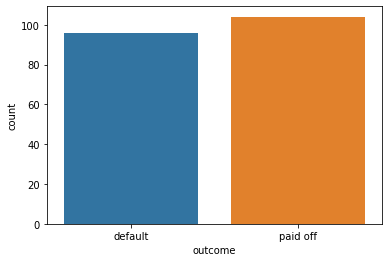

In [164]:
sns.countplot(loan200['outcome'])
plt.show()

In [165]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x, y)

newloan = x.loc[[3], predictors]
print(knn.predict_proba(newloan)) # predict 함수는 사용 불가

[[0.45 0.55]]


In [166]:
nbrs = knn.kneighbors(newloan)
max_distance = np.max(nbrs[0][0])
max_distance

6.975714033158183

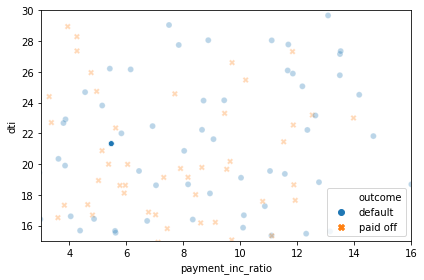

In [167]:
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', hue='outcome', data=loan200, alpha=0.3)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', hue='outcome', data=pd.concat([loan200.loc[[1], :], loan200.loc[nbrs[1][0] + 1,:]]), legend=False)
plt.xlim(3, 16)
plt.ylim(15, 30)

plt.tight_layout()
plt.show()

In [168]:
### Add scaler
loan_data = pd.read_csv("./Practical_Statictics/data/loan_data.csv.gz")
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], categories=['paid off', 'default'], ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']

newloan = loan_data.loc[0:0, predictors]

x = loan_data.loc[:, predictors]
y = loan_data.loc[:, 'outcome']

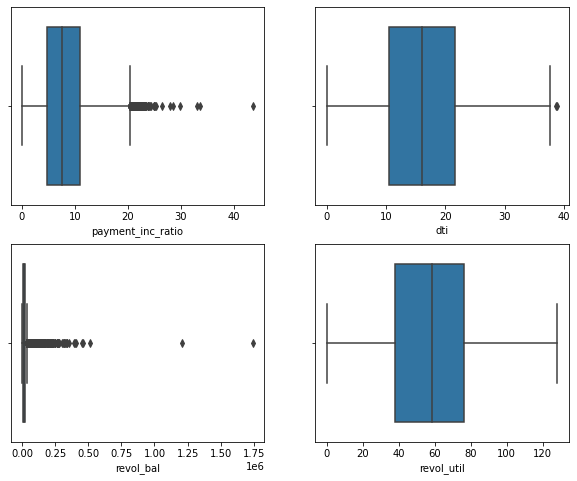

In [169]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, col in enumerate(predictors):
    row_ = i//2
    col_ = i%2
    
    sns.boxplot(loan_data[col], ax=axes[row_][col_])

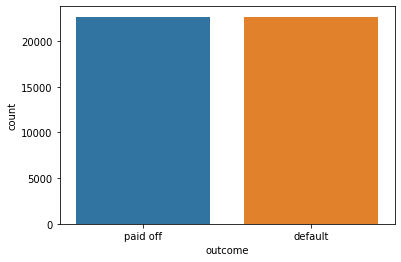

In [170]:
sns.countplot(y)
plt.show()

In [171]:
### Log Transformation & scaling
log_col = ['payment_inc_ratio', 'revol_bal']

for col in log_col:
    x[col] = np.log1p(x[col])

scaler = StandardScaler()

x_std = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
newloan_std = scaler.transform(newloan)

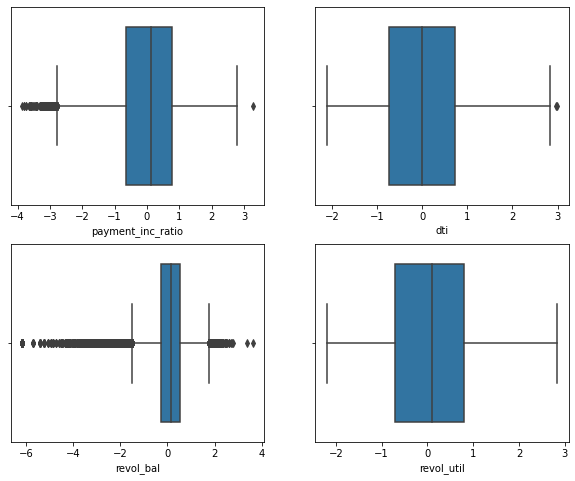

In [172]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, col in enumerate(predictors):
    row_ = i//2
    col_ = i%2
    
    sns.boxplot(x_std[col], ax=axes[row_][col_])

In [173]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_std, y)

nbrs = knn.kneighbors(newloan_std)
x.iloc[nbrs[1][0], :].head()

,payment_inc_ratio,dti,revol_bal,revol_util
43634,1.491676,33.48,14.371271,29.5
5561,1.348315,11.38,14.003947,56.0
5636,1.384923,23.46,13.140129,91.7
44392,1.622996,23.61,13.043487,87.4
14631,1.765311,16.44,13.020291,89.9


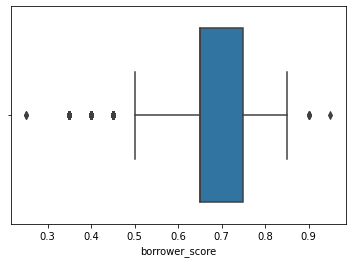

In [174]:
### KNN as a feature
loan_data['borrower_score'] = knn.predict_proba(x)[:, 0]
sns.boxplot(loan_data['borrower_score'])
plt.show()

array([0.55, 0.65, 0.7 , ..., 0.6 , 0.65, 0.6 ])

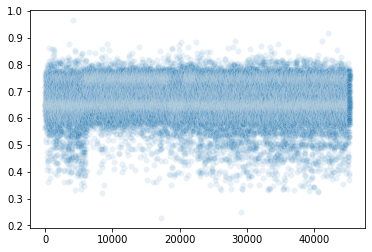

In [175]:
sns.scatterplot(x=range(len(x)), y=[bs + random.gauss(0, 0.015) for bs in knn.predict_proba(x)[:, 0]], alpha=0.1)
knn.predict_proba(x)[:, 0]

In [176]:
x_std['borrower_score'] = loan_data['borrower_score']

In [177]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2)

In [178]:
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()

rf_clf.fit(x_train.drop('borrower_score', axis=1), y_train)
lr_clf.fit(x_train.drop('borrower_score', axis=1), y_train)

rf_pred = rf_clf.predict(x_test.drop('borrower_score', axis=1))
lr_pred = lr_clf.predict(x_test.drop('borrower_score', axis=1))

print("Without borrower_score")
print(f"RandomForest: {round(accuracy_score(y_test, rf_pred), 4)}, Logisitc: {round(accuracy_score(y_test, lr_pred), 4)}")
print("")

rf_clf.fit(x_train, y_train)
lr_clf.fit(x_train, y_train)

rf_pred = rf_clf.predict(x_test)
lr_pred = lr_clf.predict(x_test)

print("With borrower_score")
print(f"RandomForest: {round(accuracy_score(y_test, rf_pred), 4)}, Logisitc: {round(accuracy_score(y_test, lr_pred), 4)}")

Without borrower_score
RandomForest: 0.5636, Logisitc: 0.5939

With borrower_score
RandomForest: 0.5649, Logisitc: 0.5938


## Unsupervised

### (1) Credit card dataset

In [75]:
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice10_credit_card.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_TRX
0,C10001,40.900749,0.818182,95.40,0.166667,2
1,C10002,3202.467416,0.909091,0.00,0.000000,0
2,C10003,2495.148862,1.000000,773.17,1.000000,12
3,C10004,1666.670542,0.636364,1499.00,0.083333,1
4,C10005,817.714335,1.000000,16.00,0.083333,1


In [76]:
df = df.drop('CUST_ID', axis=1)

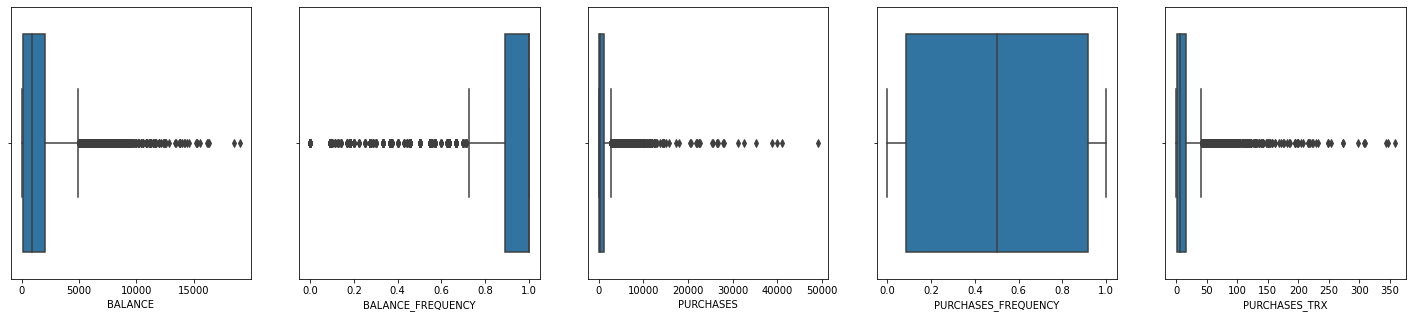

In [78]:
fig, axes = plt.subplots(ncols=5, figsize=(25, 5))
for i, col in enumerate(df.columns):
    sns.boxplot(df[col], ax=axes[i])

In [79]:
print('CUST_ID 변수는 데이터를 구분하기 위한 ID 값이므로 제거한다. 나머지 5개 변수의 분포를 boxplot으로 확인해 본 결과, PURCHASES_FREQUENCY 변수를 제외하고는 skew가 있고 이상치가 다수 관측됨을 확인하였다.')

CUST_ID 변수는 데이터를 구분하기 위한 ID 값이므로 제거한다. 나머지 5개 변수의 분포를 boxplot으로 확인해 본 결과, PURCHASES_FREQUENCY 변수를 제외하고는 skew가 있고 이상치가 다수 관측됨을 확인하였다.


In [80]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import RobustScaler

In [81]:
scaler = RobustScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)

In [83]:
print('다수 이상치가 있는 변수들의 scaling을 위해 RobustScaler를 이용하였다.')

다수 이상치가 있는 변수들의 scaling을 위해 RobustScaler를 이용하였다.


In [84]:
### elbow plot
def elbow(x):
    sse=[]
    for i in range(1, 11):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(x)
        sse.append(km.inertia_)
    
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    
    print(sse)

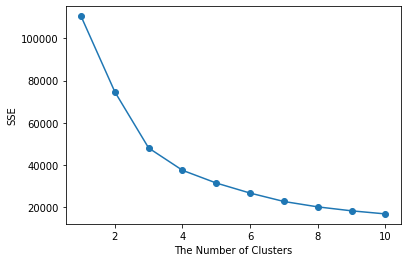

[110463.06336127294, 74642.9458234488, 48053.78459756248, 37510.34373600032, 31477.54871009831, 26719.172449677306, 22741.057528002824, 20188.954787528477, 18322.82956400067, 16857.896840083202]


In [85]:
elbow(scaled_df)

In [86]:
print('군집 분석 알고리즘으로 K-means와 DBSCAN을 수행한다. 먼저 K-means 군집분석을 수행하기 위해 elbow plot을 그려본 결과, n=3에서 elbow가 관측됨을 그래프로 확인할 수 있다.')

군집 분석 알고리즘으로 K-means와 DBSCAN을 수행한다. 먼저 K-means 군집분석을 수행하기 위해 elbow plot을 그려본 결과, n=3에서 elbow가 관측됨을 그래프로 확인할 수 있다.


In [88]:
#최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters=3, random_state=1)
km.fit(scaled_df)

# 할당된 군집을 데이터에 추가
new_labels = km.labels_
df['cluster'] = new_labels

In [90]:
dbscan = DBSCAN()

In [91]:
dbscan_cluster = dbscan.fit_predict(scaled_df)
df['cluster_dbscan'] = dbscan_cluster

In [92]:
from sklearn.metrics import silhouette_score

In [93]:
### Model compare
silhouette_score(scaled_df, km.labels_)

0.5678401215476035

In [95]:
silhouette_score(scaled_df, dbscan_cluster)

0.06245346319406094

In [100]:
print('실루엣 계수는 군집 내 응집도와 군집 간 분리도를 측정하는 값이다. 실루엣 계수로 미루어봤을 때, 계수 값이 1에 가까운 K-means가 더 적합한 모델로 생각된다.')

실루엣 계수는 군집 내 응집도와 군집 간 분리도를 측정하는 값이다. 실루엣 계수로 미루어봤을 때, 계수 값이 1에 가까운 K-means가 더 적합한 모델로 생각된다.


In [98]:
### Cluster features
df.drop('cluster_dbscan', axis=1, inplace=True)

In [99]:
cal_mean = df.groupby('cluster').mean()
cal_mean

,BALANCE,BALANCE_FREQUENCY,PURCHASES,PURCHASES_FREQUENCY,PURCHASES_TRX
cluster,,,,,
0,1729.148448,0.971156,702.322980,0.497576,11.485800
1,182.199062,0.390395,376.360349,0.293165,5.018468
2,3255.914140,0.988214,6844.667849,0.951414,85.730620


In [101]:
print('1번 클러스터의 고객들은 잔고도 적고, 잔고 업데이트 빈도도 적은 군집이다. 구매액, 빈도, 건수 모두 적어 신용카드를 거의 사용하지 않는 고객군이다.')
print('2번 클러스터의 고객들은 잔고가 가장 많으며, 업데이트 빈도도 가장 높다. 구매액과 빈도, 건수 모두 타 군집에 비해 월등이 높으므로 우수 고객군으로 볼 수 있다.')
print('0번 클러스터의 고객들은 잔고가 어느 정도 있고 업데이트 빈도도 높은 편이지만, 구매 관련 지표들은 높지 않은 고객군이다. 카드 사용을 적극 독려한다면 우수 고객군으로 넘어갈 수 있는 잠재 고객으로 볼 수 있다.')

1번 클러스터의 고객들은 잔고도 적고, 잔고 업데이트 빈도도 적은 군집이다. 구매액, 빈도, 건수 모두 적어 신용카드를 거의 사용하지 않는 고객군이다.
2번 클러스터의 고객들은 잔고가 가장 많으며, 업데이트 빈도도 가장 높다. 구매액과 빈도, 건수 모두 타 군집에 비해 월등이 높으므로 우수 고객군으로 볼 수 있다.
0번 클러스터의 고객들은 잔고가 어느 정도 있고 업데이트 빈도도 높은 편이지만, 구매 관련 지표들은 높지 않은 고객군이다. 카드 사용을 적극 독려한다면 우수 고객군으로 넘어갈 수 있는 잠재 고객으로 볼 수 있다.


In [105]:
### predict
km.predict(np.array([3000, 1, 6000, 1, 100]).reshape(1, -1))

array([2], dtype=int32)

In [106]:
print('해당 고객은 잔고도 많고, 업데이트 빈도가 매우 높다. 또한, 구매 관련 지표들도 매우 높은 편에 속하므로 2번 클러스터에 배정하는 것이 가장 타당하다. 모델을 통해 예측했을 때에도 동일한 결과를 얻었다.')

해당 고객은 잔고도 많고, 업데이트 빈도가 매우 높다. 또한, 구매 관련 지표들도 매우 높은 편에 속하므로 2번 클러스터에 배정하는 것이 가장 타당하다. 모델을 통해 예측했을 때에도 동일한 결과를 얻었다.


In [107]:
print('1번 클러스터의 고객들은 구매 관련 지표도 높지 않지만, 연결된 계좌의 잔고도 많지 않기 때문에 구매력이 높지 않다. 구매력이 낮은 경우 필수적인 소비에 집중해야 하고, 작은 할인에도 민감하게 반응하는 경우가 많으므로 대중교통, 공과금 등을 결제할 때의 할인 혜택 추가를 제안한다.')
print('2번 클러스터인 우수 고객군에게는 VIP 제도를 도입하여 특별 대우를 받을 수 있도록 하여 기존의 카드 사용을 더욱 독려한다.')
print('0번 클러스터의 잠재력이 높은 고객은 구매력은 충분하지만 실제 구매로는 이어지지 않는 경우이다. 해당 군집을 대상으로 하는 프로모션을 기획하여 카드 혜택을 늘린다.')

1번 클러스터의 고객들은 구매 관련 지표도 높지 않지만, 연결된 계좌의 잔고도 많지 않기 때문에 구매력이 높지 않다. 구매력이 낮은 경우 필수적인 소비에 집중해야 하고, 작은 할인에도 민감하게 반응하는 경우가 많으므로 대중교통, 공과금 등을 결제할 때의 할인 혜택 추가를 제안한다.
2번 클러스터인 우수 고객군에게는 VIP 제도를 도입하여 특별 대우를 받을 수 있도록 하여 기존의 카드 사용을 더욱 독려한다.
0번 클러스터의 잠재력이 높은 고객은 구매력은 충분하지만 실제 구매로는 이어지지 않는 경우이다. 해당 군집을 대상으로 하는 프로모션을 기획하여 카드 혜택을 늘린다.
